In [1]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import sys

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import abstract_gradient_training as agt
from abstract_gradient_training.bounds import interval_bound_propagation as ibp
from abstract_gradient_training import AGTConfig

sys.path.append('../')
from models.fully_connected import FullyConnected
from datasets.halfmoons import get_dataloaders

# Preliminaries

Set the plotting style, abstract gradient training configuration, prepare the half-moons dataset and initialise the model.

In [75]:
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)

# Prepare the dataset
DL_TRAIN, DL_TEST = get_dataloaders(BATCHSIZE)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY).float()

# Sweep and plotting functions

Define functions for sweeping over a specific AGT config parameter and plotting the results as a contour plot.

In [105]:
def run_sweep(sweep_variable, sweep_values, config):
    """
    For the config parameter with name sweep_variable, run certified training for sweep_variable set to each value
    in sweep_values.
    """
    config = copy.deepcopy(config)
    results = []
    for v in sweep_values:
        config.__setattr__(sweep_variable, v)
        torch.manual_seed(SEED)
        param_l, param_n, param_u = agt.poison_certified_training(MODEL, config, DL_TRAIN, DL_TEST)
        results.append((v, param_l, param_n, param_u))
    return results


def plot_sweep(results, sweep_variable_label, ax):
    """
    Given the parameter bounds in the results list returned from run_sweep, compute the worst-case predictions for a
    grid of points covering the half-moon dataset and plot the results as a contour plot.
    """

    # get the bounds of the dataset for plotting
    x_test, y_test = DL_TEST.dataset.tensors
    x_min, x_max = x_test[:, 0].min() - 0.5, x_test[:, 0].max() + 0.5
    y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5

    # initialise axes
    # fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    # define a grid of points to evaluate the model at
    x = torch.linspace(x_min, x_max, GRIDSIZE)
    y = torch.linspace(y_min, y_max, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    # add polynomial features
    in_data = torch.stack(
        (
            X.flatten(),
            Y.flatten(),
            X.flatten() ** 2,
            Y.flatten() ** 2,
            X.flatten() ** 3,
            Y.flatten() ** 3,
        ),
        dim=1,
    )
    in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float()

    # compute the nominal model predictions
    param_n = results[0][2]
    *_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
    logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
    worst_case_0 = torch.zeros_like(logits)
    worst_case_1 = torch.zeros_like(logits)
    logits = logits.detach().cpu().numpy()
    ax.contour(X, Y, logits, cmap=CM, alpha=1.0, levels=[0.5])

    # for each result in the sweep, compute the worst-case predictions for the entire grid
    for _, param_l, param_n, param_u in results:
        (*_, logits_l), (*_, logits_u) = ibp.bound_forward_pass(param_l, param_u, in_data, in_data)
        worst_case_0 += torch.hstack([logits_l[:, 0], logits_u[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
        worst_case_1 += 1 - torch.hstack([logits_u[:, 0], logits_l[:, 1]]).argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)

    # plot the worst-case predictions
    worst_case = torch.min(worst_case_0, worst_case_1).detach().cpu().numpy()
    boundaries = list(range(-1, len(results) + 1, 1))
    norm = mpl.colors.Normalize(vmin=worst_case.min(), vmax=worst_case.max())
    ax.contourf(X, Y, worst_case, cmap=CM, norm=norm, levels=boundaries)

    # define custom legend
    custom_lines, custom_labels = [], []
    for i in range(len(results)):
        custom_lines.append(
            mpl.lines.Line2D(
                [0], [0], marker="o", lw=0, markerfacecolor=CM(norm(i +1)), color="grey", alpha=0.8, markersize=15
            )
        )
        custom_labels.append(f"${sweep_variable_label}={results[i][0]}$")
    custom_labels = custom_labels[::-1]
    ax.legend(
        custom_lines, custom_labels, loc="upper right", fontsize=22, labelspacing=0.2, handletextpad=0.1, borderpad=0.25
    )

    # plot the test dataset
    ax.scatter(x_test[:, 0], x_test[:, 1], s=30, c=y_test, edgecolors="k", linewidth=1, cmap=CM_BRIGHT)

## Poisoning sweeps

[AGT] [WARNING ] [17:00:28] k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


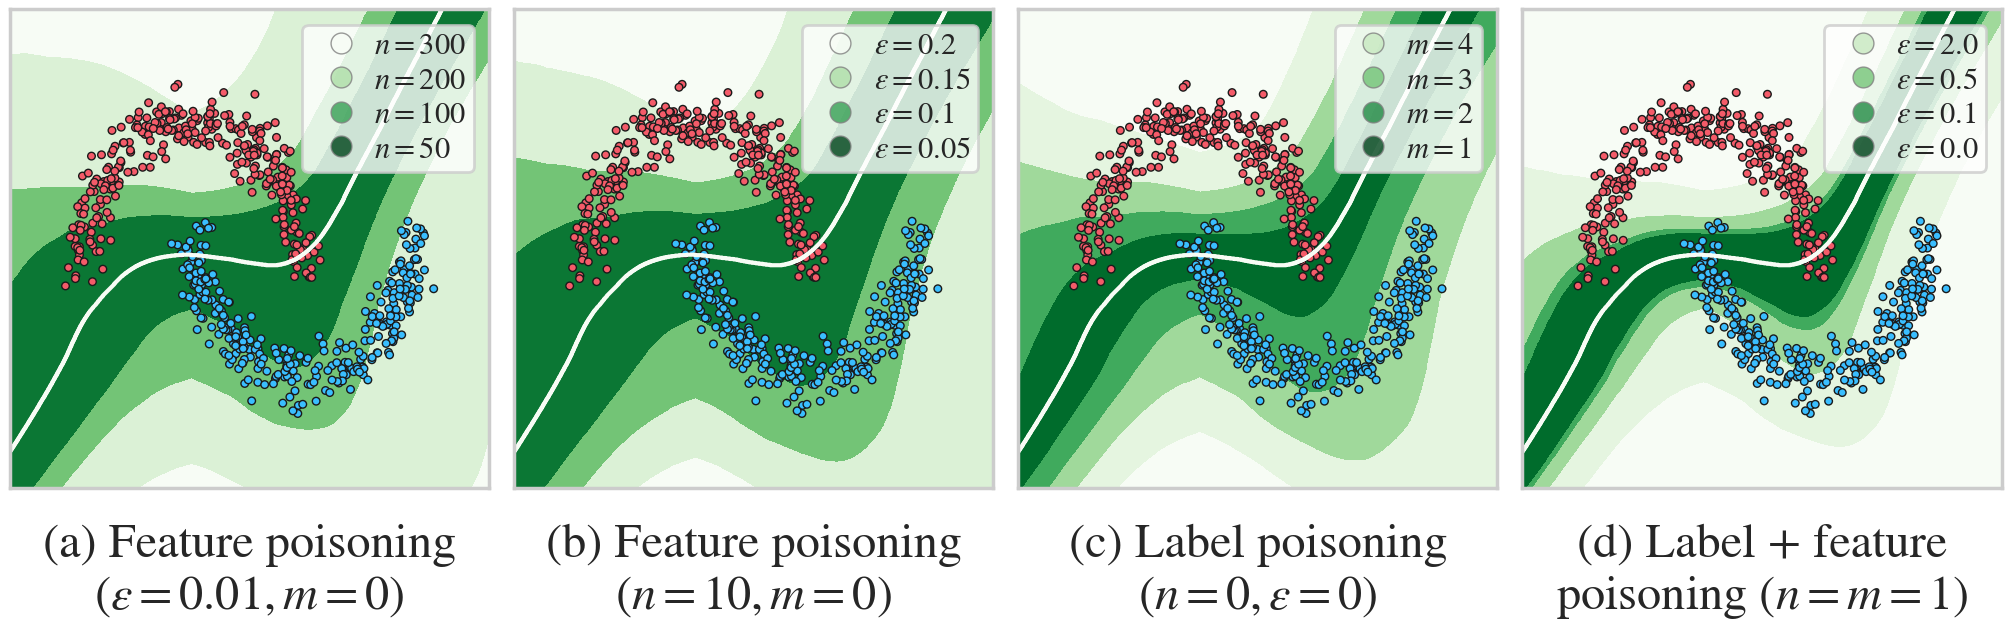

In [177]:
# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=4,
    device="cuda:0",
    forward_bound="interval",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    log_level="WARNING",
    # early_stopping=True,
)

conf = copy.deepcopy(NOMINAL_CONFIG)
epsilon_1 = 0.01
conf.epsilon = epsilon_1
results_sweep_1 = run_sweep("k_poison", [50, 100, 200, 300], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
k_poison_2 = 10
conf.k_poison = k_poison_2
results_sweep_2 = run_sweep("epsilon", [0.05, 0.1, 0.15, 0.2], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
conf.k_poison = 0
conf.epsilon = 0.0
results_sweep_3 = run_sweep("label_k_poison", [1, 2, 3, 4], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
k_poison_4 = 1
conf.label_k_poison = k_poison_4
conf.k_poison = k_poison_4
results_sweep_4 = run_sweep("epsilon", [0.0, 0.1, 0.5, 2.0], conf)

# Set plotting and functional parameters
sns.set_theme(context="poster", style="whitegrid", font_scale=1.45)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

CM = sns.color_palette(palette="Greens", n_colors=12, as_cmap=True)
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
GRIDSIZE = 1000
FIGSIZE = (20, 8)

fig, axs = plt.subplots(
    1,
    4,
    figsize=FIGSIZE,
    layout="constrained",
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
    sharey=True,
)

[ax.set_box_aspect(1) for ax in axs]
[ax.set_xticks([]) for ax in axs]
[ax.set_yticks([]) for ax in axs]
axs[0].set_xlabel(f"(a) Feature poisoning\n($\epsilon={epsilon_1}, m=0$)", labelpad=25)
axs[1].set_xlabel(f"(b) Feature poisoning\n($n={k_poison_2}, m=0$)", labelpad=25)
axs[2].set_xlabel(f"(c) Label poisoning\n($n=0, \epsilon=0$)", labelpad=25)
axs[3].set_xlabel(f"(d) Label + feature\npoisoning ($n=m={k_poison_4}$)", labelpad=25)

plot_sweep(results_sweep_1, r"n", axs[0])
plot_sweep(results_sweep_2, r"\epsilon", axs[1])
plot_sweep(results_sweep_3, r"m", axs[2])
plot_sweep(results_sweep_4, r"\epsilon", axs[3])

plt.savefig(f".figures/halfmoons_noclip.pdf", bbox_inches="tight", dpi=300)


[AGT] [WARNING ] [17:01:23] k=0 suffers from numerical instability, consider using dtype double or setting k > 0.


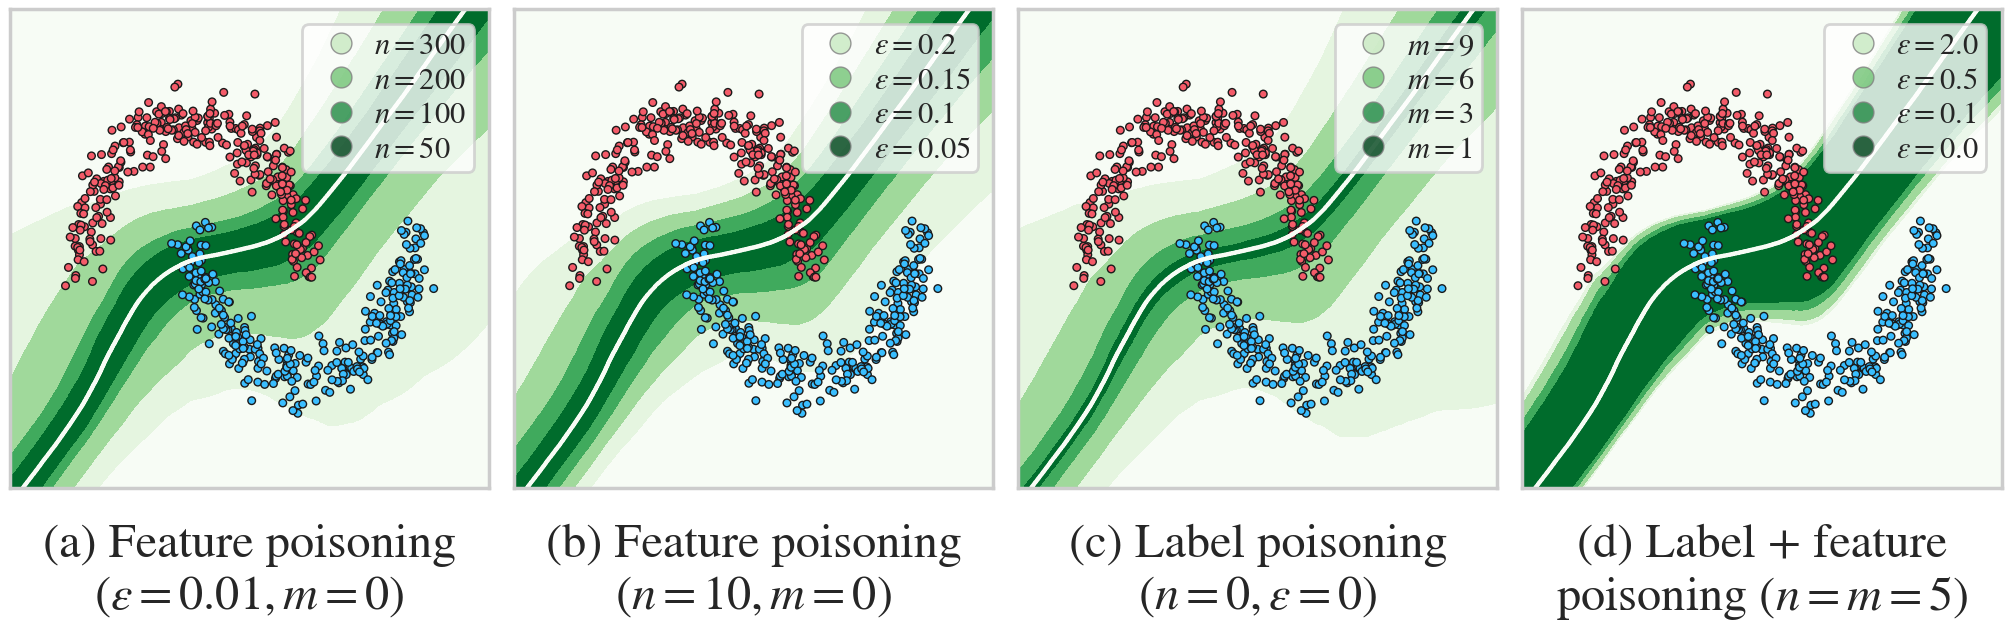

In [179]:
# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=4,
    device="cuda:0",
    forward_bound="interval",
    backward_bound="interval",
    clip_gamma=0.2,
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    log_level="WARNING",
    # early_stopping=True,
)

conf = copy.deepcopy(NOMINAL_CONFIG)
epsilon_1 = 0.01
conf.epsilon = epsilon_1
results_sweep_1 = run_sweep("k_poison", [50, 100, 200, 300], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
k_poison_2 = 10
conf.k_poison = k_poison_2
results_sweep_2 = run_sweep("epsilon", [0.05, 0.1, 0.15, 0.2], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
conf.k_poison = 0
conf.epsilon = 0.0
results_sweep_3 = run_sweep("label_k_poison", [1, 3, 6, 9], conf)

conf = copy.deepcopy(NOMINAL_CONFIG)
k_poison_4 = 5
conf.label_k_poison = k_poison_4
conf.k_poison = k_poison_4
results_sweep_4 = run_sweep("epsilon", [0.0, 0.1, 0.5, 2.0], conf)

# Set plotting and functional parameters
sns.set_theme(context="poster", style="whitegrid", font_scale=1.45)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

CM = sns.color_palette(palette="Greens", n_colors=12, as_cmap=True)
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
GRIDSIZE = 1000
FIGSIZE = (20, 8)

fig, axs = plt.subplots(
    1,
    4,
    figsize=FIGSIZE,
    layout="constrained",
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
    sharey=True,
)

[ax.set_box_aspect(1) for ax in axs]
[ax.set_xticks([]) for ax in axs]
[ax.set_yticks([]) for ax in axs]
axs[0].set_xlabel(f"(a) Feature poisoning\n($\epsilon={epsilon_1}, m=0$)", labelpad=25)
axs[1].set_xlabel(f"(b) Feature poisoning\n($n={k_poison_2}, m=0$)", labelpad=25)
axs[2].set_xlabel(f"(c) Label poisoning\n($n=0, \epsilon=0$)", labelpad=25)
axs[3].set_xlabel(f"(d) Label + feature\npoisoning ($n=m={k_poison_4}$)", labelpad=25)

plot_sweep(results_sweep_1, r"n", axs[0])
plot_sweep(results_sweep_2, r"\epsilon", axs[1])
plot_sweep(results_sweep_3, r"m", axs[2])
plot_sweep(results_sweep_4, r"\epsilon", axs[3])

plt.savefig(f".figures/halfmoons_clip.pdf", bbox_inches="tight", dpi=300)
